In [1]:
import numpy as np
import pandas as pd
#10 min slots
df = pd.read_csv('C:/Users/jeppe/Downloads/10_min_slots.csv', header=0)

In [2]:
df.head()

,ten_min_id,id,show_name,show_desc,min_start,time_length,text
0,269_0,269,#1109 - Matthew Walker,Matthew Walker is Professor of Neuroscience an...,0,10,"Hey, what's going on? Ladies and gentlemen?...."
1,269_10,269,#1109 - Matthew Walker,Matthew Walker is Professor of Neuroscience an...,10,10,They sleep in late May 2nd of these crazy dr...
2,269_20,269,#1109 - Matthew Walker,Matthew Walker is Professor of Neuroscience an...,20,10,They remember how they described it and then...
3,269_30,269,#1109 - Matthew Walker,Matthew Walker is Professor of Neuroscience an...,30,10,Does that make sense to you doesn't make sen...
4,269_40,269,#1109 - Matthew Walker,Matthew Walker is Professor of Neuroscience an...,40,10,"Yeah, it's a huge pot. How many hours of sle..."


In [3]:
df.shape

(2218, 7)

In [4]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
data = df['text'].tolist()
embeddings = model.encode(data, show_progress_bar=True)

C:\Users\jeppe\anaconda3\lib\site-packages\torch\cuda\__init__.py:82: UserWarning: CUDA initialization: CUDA driver initialization failed, you might not have a CUDA gpu. (Triggered internally at  C:\cb\pytorch_1000000000000\work\c10\cuda\CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


Batches:   0%|          | 0/70 [00:00<?, ?it/s]

In [50]:
import umap
umap_embeddings = umap.UMAP(n_neighbors=200, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings)

In [53]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=10).fit(umap_embeddings)

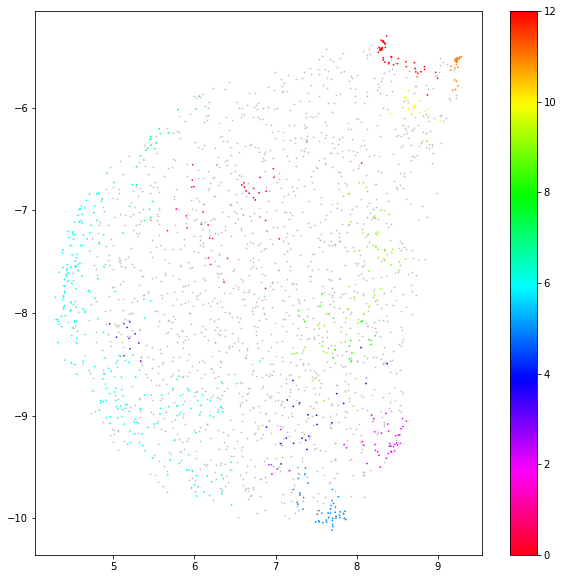

In [63]:
import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(n_neighbors=200, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(10, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.5)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.5, cmap='hsv_r')
plt.colorbar()

In [64]:
docs_df = pd.DataFrame(data, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [65]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

In [66]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

C:\Users\jeppe\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Topic,Size
0,-1,1635
7,6,243
10,9,57
6,5,46
3,2,42
13,12,41
12,11,28
8,7,23
5,4,22
2,1,18


In [61]:
top_n_words[6][:10]

[('police', 0.0011958017266124022),
 ('cops', 0.0010551515161624407),
 ('law', 0.0009130109783335351),
 ('military', 0.0009110879350089186),
 ('position', 0.0008953021058262185),
 ('racist', 0.0008928214338654175),
 ('biden', 0.000886630828096721),
 ('war', 0.0008767798163308036),
 ('states', 0.0008726922105323468),
 ('obama', 0.0008620955754540946)]

In [62]:
top_n_words[9][:10]

[('lsd', 0.001995563248009371),
 ('elephant', 0.0017590522268511857),
 ('korean', 0.0015354990784018703),
 ('jail', 0.0014424888723465266),
 ('glutathione', 0.0014006113608379198),
 ('tom', 0.001351294331868708),
 ('parking', 0.0012499311223583016),
 ('bruce', 0.0011555657752866236),
 ('comic', 0.0011553603097994858),
 ('cnn', 0.0011390540680520937)]

In [ ]:
#with smaller clusters

In [67]:
import umap
umap_embeddings2 = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings)

In [68]:
import hdbscan
cluster2 = hdbscan.HDBSCAN(min_cluster_size=10).fit(umap_embeddings2)

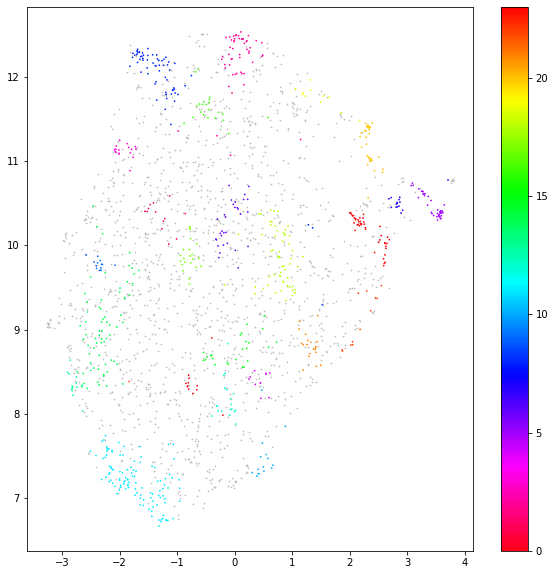

In [70]:
import matplotlib.pyplot as plt

# Prepare data
umap_data2 = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result2 = pd.DataFrame(umap_data2, columns=['x', 'y'])
result2['labels'] = cluster2.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(10, 10))
outliers2 = result2.loc[result2.labels == -1, :]
clustered2 = result2.loc[result2.labels != -1, :]
plt.scatter(outliers2.x, outliers2.y, color='#BDBDBD', s=0.5)
plt.scatter(clustered2.x, clustered2.y, c=clustered2.labels, s=0.5, cmap='hsv_r')
plt.colorbar()

In [71]:
docs_df2 = pd.DataFrame(data, columns=["Doc"])
docs_df2['Topic'] = cluster2.labels_
docs_df2['Doc_ID'] = range(len(docs_df2))
docs_per_topic2 = docs_df2.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [74]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf2, count2 = c_tf_idf(docs_per_topic2.Doc.values, m=len(data))

In [75]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words2 = extract_top_n_words_per_topic(tf_idf2, count2, docs_per_topic2, n=20)
topic_sizes2 = extract_topic_sizes(docs_df2); topic_sizes2.head(10)

C:\Users\jeppe\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Topic,Size
0,-1,1471
12,11,113
15,14,69
9,8,65
19,18,58
3,2,53
24,23,43
6,5,39
21,20,35
7,6,31


In [79]:
top_n_words2[11][:10]

[('agree', 0.0010962766414285303),
 ('ideas', 0.0010792062285490337),
 ('difficult', 0.0010040786207183485),
 ('gender', 0.0009607790745060162),
 ('mice', 0.0009394754719432145),
 ('dopamine', 0.0009331142884867504),
 ('message', 0.0009178287347186503),
 ('vote', 0.0009121769090712993),
 ('change', 0.0009055598828881385),
 ('coca', 0.0008932228089869053)]

In [80]:
top_n_words2[14][:10]

[('racist', 0.0018426766308345457),
 ('assange', 0.0014662933867007444),
 ('military', 0.0014433793475912798),
 ('court', 0.0014331929350935354),
 ('obama', 0.0013762876969818138),
 ('bat', 0.001330698126222011),
 ('julian', 0.001324268935613095),
 ('president', 0.0013173509354540407),
 ('amp', 0.0012689775274526219),
 ('supreme', 0.0012269416902336897)]

In [81]:
top_n_words2[8][:10]

[('leg', 0.002788662299170329),
 ('fights', 0.0027878603077541963),
 ('beat', 0.002603433123097059),
 ('john', 0.0023195504524893646),
 ('round', 0.0022717275014579675),
 ('knocked', 0.0022426877640321077),
 ('boxing', 0.002227258867490781),
 ('fought', 0.0021848176703220083),
 ('anderson', 0.0020515013612530776),
 ('champion', 0.002036703420802855)]